In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import random
import cv2
from pathlib import Path

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

IMG_SIZE = 128 
BATCH_SIZE = 32
EPOCHS = 10

dataset_path = r"C:\Users\ADMIN\Desktop\Jupyter Project\Dataset-train+val+test"

In [ ]:

def load_dataset(base_path):
    
    print(f"Loading dataset from {base_path}")
    
    train_path = os.path.join(base_path, 'train')
    val_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')
    
    for path in [train_path, val_path, test_path]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Directory not found: {path}")
    
    class_names = sorted([item.name for item in os.scandir(train_path) if item.is_dir()])
    print(f"Found {len(class_names)} classes: {class_names}")
    
    train_images = sum([len([f for f in os.listdir(os.path.join(train_path, class_name)) 
                         if os.path.isfile(os.path.join(train_path, class_name, f))]) 
                     for class_name in class_names])
    
    val_images = sum([len([f for f in os.listdir(os.path.join(val_path, class_name)) 
                       if os.path.isfile(os.path.join(val_path, class_name, f))]) 
                   for class_name in class_names])
    
    test_images = sum([len([f for f in os.listdir(os.path.join(test_path, class_name)) 
                        if os.path.isfile(os.path.join(test_path, class_name, f))]) 
                    for class_name in class_names])
    
    print(f"Train images: {train_images}")
    print(f"Validation images: {val_images}")
    print(f"Test images: {test_images}")
    print(f"Total images: {train_images + val_images + test_images}")
    
    # Create image generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_ds = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=RANDOM_SEED
    )
    
    val_ds = val_test_datagen.flow_from_directory(
        val_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_ds = val_test_datagen.flow_from_directory(
        test_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_ds, val_ds, test_ds, class_names, test_path

train_ds, val_ds, test_ds, class_names, test_path = load_dataset(dataset_path)


print("Dataset loaded successfully!")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt

# Reduce image size to speed up training
IMG_SIZE = 128  

def build_model(num_classes):
    """Build a CNN model using transfer learning."""
    base_model = applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )
    
    # Freeze the base model to use pretrained features
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model with Adam optimizer for faster training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(model, train_ds, val_ds, epochs=5):  # Reduce epochs to save time
    """Train the model with early stopping."""
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history

def visualize_training_history(history):
    """Visualize the training history."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Build the model
model = build_model(len(class_names))
model.summary()

# Train the model
history = train_model(model, train_ds, val_ds)

# Visualize training history
visualize_training_history(history)
print("Model training completed!")

In [ ]:

def evaluate_model(model, test_ds, class_names):

    y_true = []
    y_pred = []
    
    test_ds.reset()
    
    print("Evaluating model on test set...")
    for i in range(len(test_ds)):
        batch_x, batch_y = test_ds[i]
        batch_pred = model.predict(batch_x, verbose=0)
        
        y_true.extend(np.argmax(batch_y, axis=1))
        y_pred.extend(np.argmax(batch_pred, axis=1))
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

evaluate_model(model, test_ds, class_names)

In [ ]:

def test_random_image(model, test_path, class_names):
   
    random_class = random.choice(class_names)
    class_path = os.path.join(test_path, random_class)
    
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and 
                  f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No image files found in {class_path}")
        return
        
    random_image = random.choice(image_files)
    image_path = os.path.join(class_path, random_image)
    
    print(f"Selected random image: {image_path}")
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Original Image (True class: {random_class})")
    plt.axis('off')
    plt.show()
    
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = img_resized / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index] * 100
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_resized)
    plt.title(f"Prediction Results\nTrue class: {random_class}\nPredicted: {predicted_class} ({confidence:.2f}% confidence)")
    plt.axis('off')
    plt.savefig('random_test_image_prediction.png')
    plt.show()
    
    print(f"\nPrediction Results:")
    print(f"True Class: {random_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, prediction[0] * 100)
    plt.xlabel('Classes')
    plt.ylabel('Probability (%)')
    plt.title('Class Probabilities')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('class_probabilities.png')
    plt.show()
    
    print("\nDisease Information:")
    if predicted_class == "NORMAL":
        print("Prediction: Healthy retina - No signs of retinal disease detected")
    elif predicted_class == "CNV":
        print("Prediction: Choroidal Neovascularization (CNV)")
        print("- Condition where abnormal blood vessels grow under the retina")
        print("- Often associated with wet Age-related Macular Degeneration (AMD)")
        print("- Can cause vision loss, bleeding, and fluid leakage in the retina")
    elif predicted_class == "DME":
        print("Prediction: Diabetic Macular Edema (DME)")
        print("- Diabetes-related eye disease with fluid accumulation in the macula")
        print("- Caused by leaky blood vessels due to diabetic retinopathy")
        print("- Can lead to blurred vision and difficulty recognizing faces or reading")
    elif predicted_class == "DRUSEN":
        print("Prediction: Drusen")
        print("- Yellow deposits under the retina often linked to Age-related Macular Degeneration")
        print("- Caused by waste buildup from retinal cells")
        print("- Large drusen increase the risk of vision loss")

test_random_image(model, test_path, class_names)

Loading MobileNetV2 model...


Enter the path to the image you want to analyze:  C:\Users\ADMIN\Desktop\Jupyter Project\Dataset-train+val+test\test\NORMAL\NORMAL-3913611-7.jpeg


Analyzing image: C:\Users\ADMIN\Desktop\Jupyter Project\Dataset-train+val+test\test\NORMAL\NORMAL-3913611-7.jpeg
Using convolutional layer: out_relu
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: nematode (91.04%)


C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_160']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


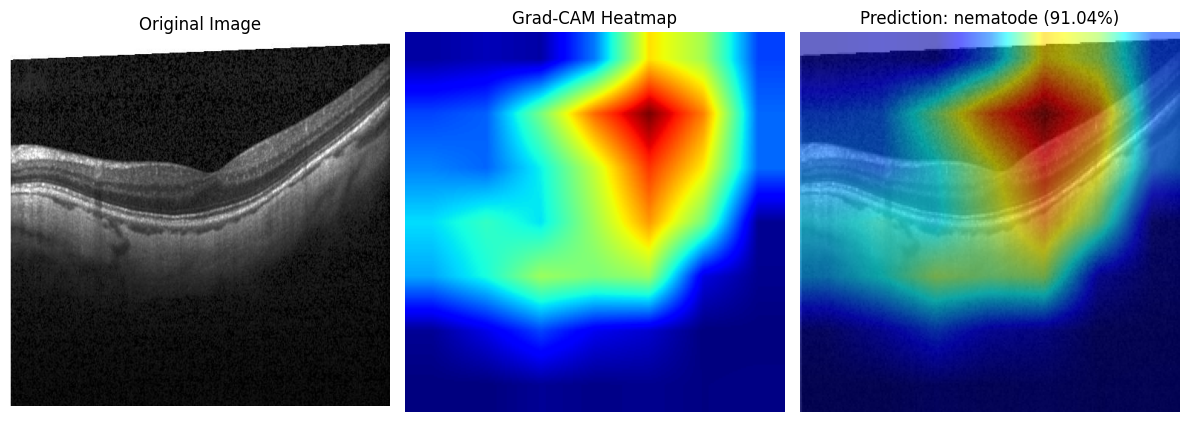

In [7]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import os

# Set up parameters
IMG_SIZE = 224  # MobileNetV2's expected input size

def get_layer_from_model(model, layer_name):
    """
    Recursively search for a layer with the given name in the model or its sub-models.
    
    Args:
        model (tf.keras.Model): The model to search.
        layer_name (str): The name of the layer to find.
        
    Returns:
        tf.keras.layers.Layer: The found layer.
        
    Raises:
        ValueError: If the layer is not found.
    """
    try:
        return model.get_layer(layer_name)
    except ValueError:
        for layer in model.layers:
            if isinstance(layer, tf.keras.Model):
                try:
                    return get_layer_from_model(layer, layer_name)
                except ValueError:
                    continue
        raise ValueError(f"Layer {layer_name} not found in the model or its sub-models.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given preprocessed image.
    """
    # First, get the target layer
    target_layer = get_layer_from_model(model, last_conv_layer_name)
    
    # Create a model mapping inputs to the target conv layer output and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [target_layer.output, model.output]
    )
    
    # Run the model directly
    with tf.GradientTape() as tape:
        # Use tf.convert_to_tensor to ensure the input is handled correctly
        inputs = tf.convert_to_tensor(img_array)
        
        # Run the forward pass
        conv_outputs, predictions = grad_model(inputs)
        
        # If no specific prediction index is provided, use the top predicted class
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        
        # Get the target class output
        class_channel = predictions[:, pred_index]
    
    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Create a compatible shape for broadcasting
    pooled_grads = tf.reshape(pooled_grads, (1, 1, 1, -1))
    
    # Generate the heatmap by weighing feature maps with gradients
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=3)
    
    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) 
    max_val = tf.reduce_max(heatmap)
    if max_val != 0:
        heatmap = heatmap / max_val
    
    # Remove the batch dimension and convert to numpy
    return heatmap[0].numpy()

def display_gradcam(image_path, model, last_conv_layer_name, preprocessing_fn=None, decode_fn=None, alpha=0.4):
    """
    Loads an image, generates a Grad-CAM heatmap, and overlays it on the original image.
    """
    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return
    
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return
    
    # Convert BGR to RGB (OpenCV loads images in BGR format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the input image
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    
    # Preprocess the image
    if preprocessing_fn:
        # Convert to array and add batch dimension
        x = np.expand_dims(img_resized.copy(), axis=0)
        # Apply model-specific preprocessing
        x = preprocessing_fn(x)
    else:
        # Simple normalization if no specific preprocessing function
        x = np.expand_dims(img_resized, axis=0) / 255.0
    
    # Make prediction
    preds = model.predict(x)
    pred_index = np.argmax(preds[0])
    
    # Decode the prediction if a decode function is provided
    if decode_fn:
        decoded_pred = decode_fn(preds, top=1)[0]
        prediction_info = f"{decoded_pred[0][1]} ({decoded_pred[0][2]:.2%})"
    else:
        prediction_info = f"Class {pred_index} ({preds[0][pred_index]:.2%})"
    
    print(f"Predicted: {prediction_info}")
    
    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name, pred_index)
    
    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))
    
    # Convert heatmap to RGB format for visualization
    heatmap_rgb = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Superimpose the heatmap on original image
    superimposed_img = cv2.addWeighted(
        img_resized, 1 - alpha, heatmap_colored, alpha, 0
    )
    
    # Display the original image and the Grad-CAM visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f"Prediction: {prediction_info}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return heatmap_resized, superimposed_img

# Main execution code
if __name__ == "__main__":
    # Load a pre-trained model (MobileNetV2 in this example)
    print("Loading MobileNetV2 model...")
    model = MobileNetV2(weights='imagenet')
    
    # You can replace this with your own image path
    # For demonstration, let's allow the user to input an image path
    image_path = input("Enter the path to the image you want to analyze: ")
    
    # For MobileNetV2, the last convolutional layer is named 'out_relu'
    last_conv_layer = 'out_relu'
    
    print(f"Analyzing image: {image_path}")
    print(f"Using convolutional layer: {last_conv_layer}")
    
    # Display the Grad-CAM visualization
    display_gradcam(
        image_path=image_path,
        model=model,
        last_conv_layer_name=last_conv_layer,
        preprocessing_fn=preprocess_input,
        decode_fn=decode_predictions,
        alpha=0.6
    )